In [20]:
from pathlib import Path
from src.utils.model_utils import seed_all
from src.utils.data_class import ModelConfig, TrainConfig, DataConfig, LatentForecasterConfig, OptimConfig
from src.utils.plots import plot_forecast_with_splits, plot_target
from src.utils.hpo import random_search_tabular_latent
from pathlib import Path
import shutil

In [84]:
def empty_folder(folder: str | Path) -> None:
    p = Path(folder)
    if not p.exists() or not p.is_dir():
        raise NotADirectoryError(str(p))

    for item in p.iterdir():
        if item.is_dir():
            shutil.rmtree(item)
        else:
            item.unlink()

In [102]:
DATA = Path("./../data")

# Example: pick first file
files = sorted([p for p in DATA.glob("*.csv")])
if not files:
    raise SystemExit(f"No CSVs found in {DATA}")


seed = 42
seed_all(seed)

HORIZON = 1000
SPLIT_RATIO = (0.6, 0.2, 0.2)


empty_folder("./../output/reports/")


In [109]:
csv_path = str(files[2])

In [110]:
csv_path

'..\\data\\ETTh2.csv'

C:\Users\janav\Documents\projects\iterative-long-term-forecasting\src\utils\plots.py:52: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


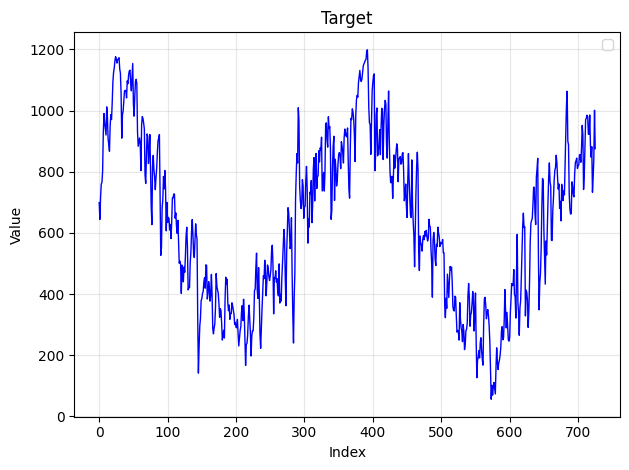

In [111]:
plot_target(csv_path, 'y')

In [112]:
# HPO search space for your TabularAutoencoder + latent 1-step forecaster setup.
# All values are discrete; random_search_tabular_latent samples uniformly.

space = {
    # -------------------------
    # Data / splitting
    # -------------------------
    "data_cfg.split_ratio": [
        #(0.6, 0.2, 0.2),
        (0.7, 0.1, 0.2),
        #(0.7, 0.15, 0.15),
        #(0.8, 0.1, 0.1),
    ],
    "data_cfg.horizon": [100],

    # Feature engineering
    "data_cfg.lags": [
        (1, 2, 7, 14, 30),
        (1, 7, 14, 28),
        (1, 2, 3, 7, 14),
        #(1, 24, 48, 72),          # if your data is hourly
        #(1, 24, 168),             # daily + weekly cycle style (hourly data)
    ],
    "data_cfg.rolling_windows": [
        (3, 7),
        #(3, 7, 14),
        (7, 14),
       # (3, 7, 14, 30),
    ],

    # -------------------------
    # AE architecture
    # -------------------------
    "model_cfg.latent_dim": [2, 4, 6, 8, 10],
    "model_cfg.hidden": [32, 64, 128, 256],
    "model_cfg.layers": [1, 2],
    "model_cfg.activation": ["relu"],
    "model_cfg.dropout": [0.0, 0.05],

    # VAE on/off + KL strength
    "model_cfg.variational": [False],
    "model_cfg.beta_kl": [0.0, 1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 3e-3],

    # If you keep VAE True, keep stability
    "model_cfg.latent_cfg.use_mu_not_sample": [True],  # do not sample during forecasting

    # -------------------------
    # Latent forecaster (sklearn)
    # -------------------------
    "model_cfg.latent_cfg.regressor_name": [
       #"linear",
       "ridge",
       #"lasso",
       #"elasticnet",
        "random_forest",
        #"extra_trees",
        "xgboost",
    ],

    # RF / ExtraTrees variants (your build_regressor should ignore unused keys)
    "model_cfg.latent_cfg.regressor_params": [
        # conservative
        {"n_estimators": 200, "random_state": seed, },
        {"n_estimators": 400, "random_state": seed, },
        {"n_estimators": 600, "random_state": seed, },
    ],

    # -------------------------
    # AE training
    # -------------------------
    "train_cfg.epochs_ae": [100],
    "train_cfg.loss_fn": ["mse"],
    "train_cfg.grad_clip": [None],
    "train_cfg.early_stop_patience": [5],

    # Optim
    "model_cfg.optim.name": ["adamw", "adam"],
    "model_cfg.optim.lr": [0.00001, 0.0001, 0.001],
    "model_cfg.optim.weight_decay": [0.0, 1e-4, 1e-3],
}


In [113]:
data_cfg = DataConfig(
csv_path=csv_path,
target_col="y",
datetime_col="datetime",
batch_size=128, 
split_ratio=SPLIT_RATIO,
horizon=HORIZON
)
model_cfg = ModelConfig(
latent_dim=6,
horizon=HORIZON,
latent_cfg=LatentForecasterConfig(regressor_params={
    "n_estimators":100
}),
optim=OptimConfig(name="adam", lr=0.0001, weight_decay=0),
layers=2,
hidden=32,
dropout=0.01,
variational=False
)
train_cfg = TrainConfig(
epochs_ae = 100,
loss_fn="mse",
early_stop_patience=10
)





In [9]:
#meta = random_search_tabular_latent(seed, 50, space, data_cfg, model_cfg, train_cfg)

In [114]:
meta = random_search_tabular_latent(seed, 50, space, data_cfg, model_cfg, train_cfg, transitional=False)

In [115]:
trials = meta["trials"]
top10 = sorted(trials, key=lambda t: t["score"])[:10]

20260112170104_ETTh2_tabular_ld10_ridge
569


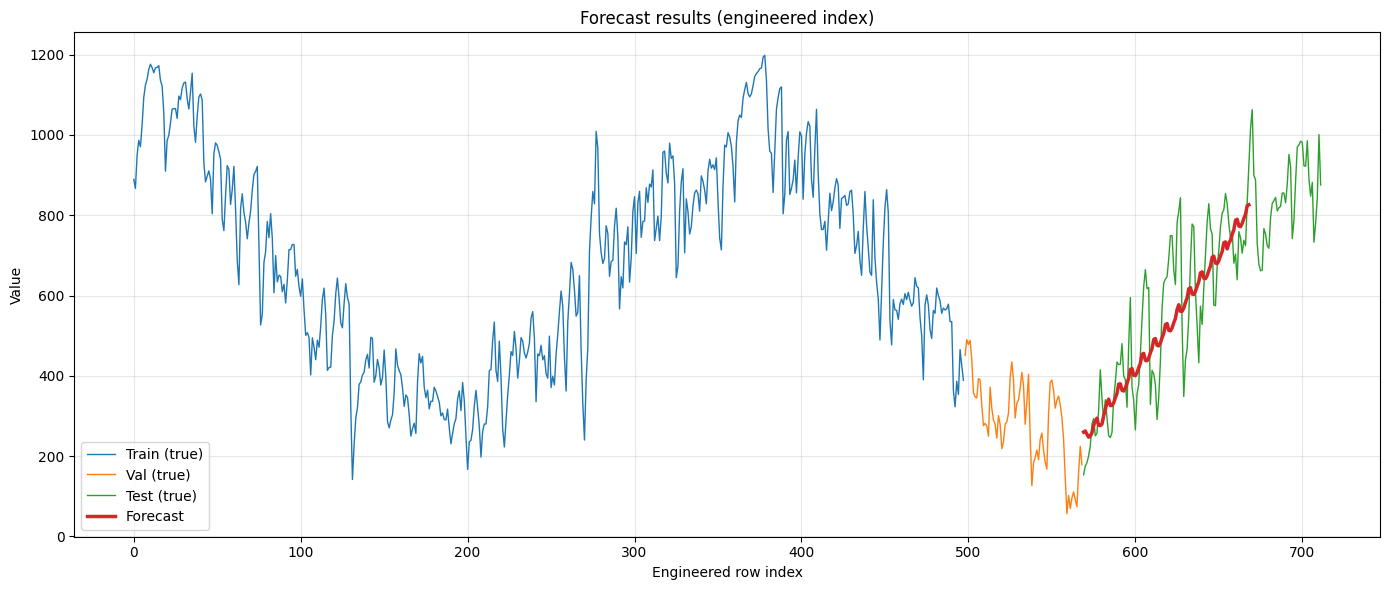

20260112170122_ETTh2_tabular_ld8_ridge
569


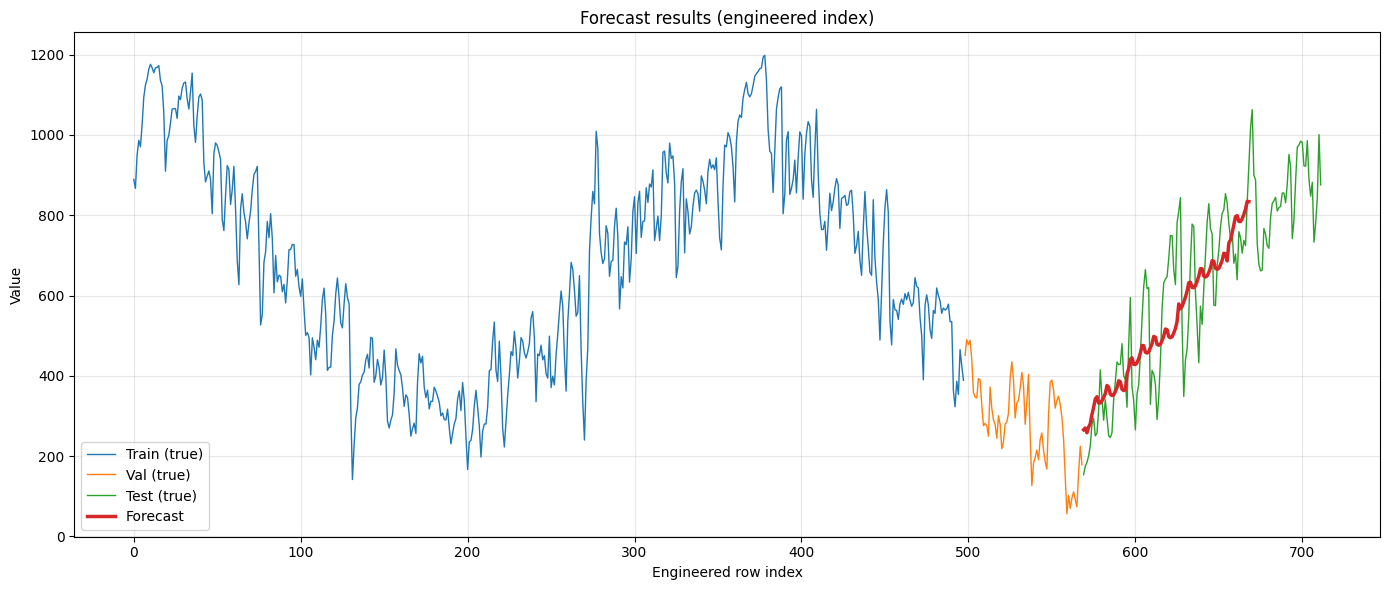

20260112170221_ETTh2_tabular_ld8_ridge
557


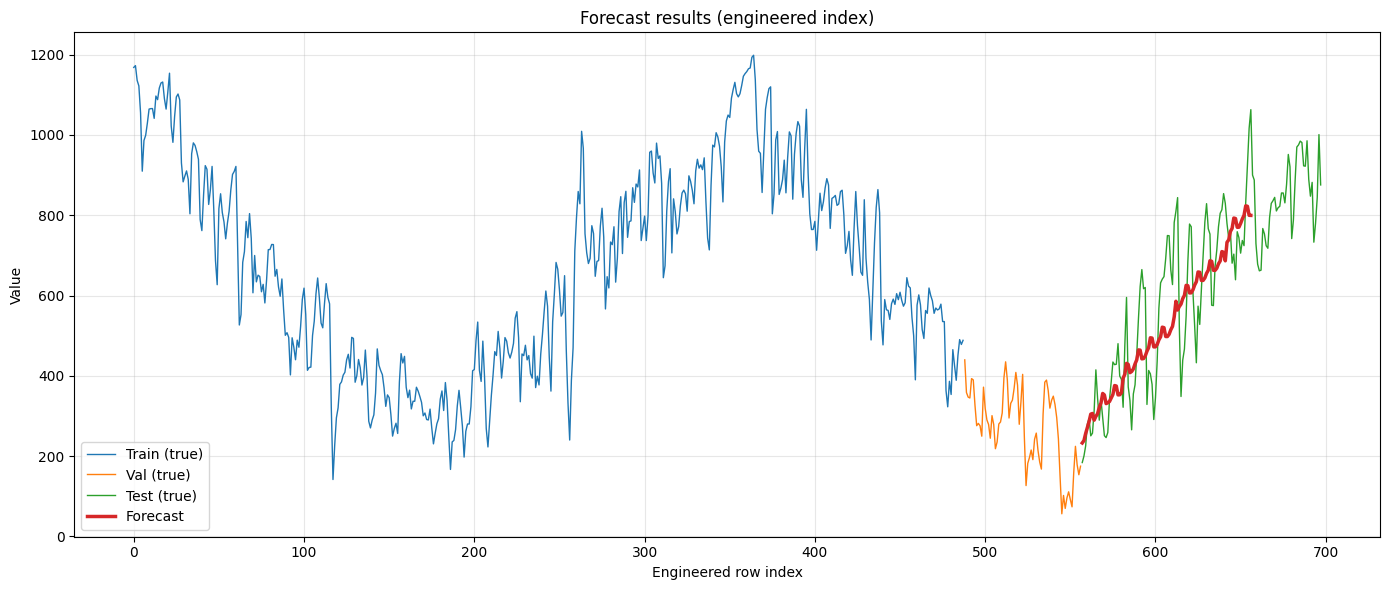

20260112170226_ETTh2_tabular_ld8_ridge
569


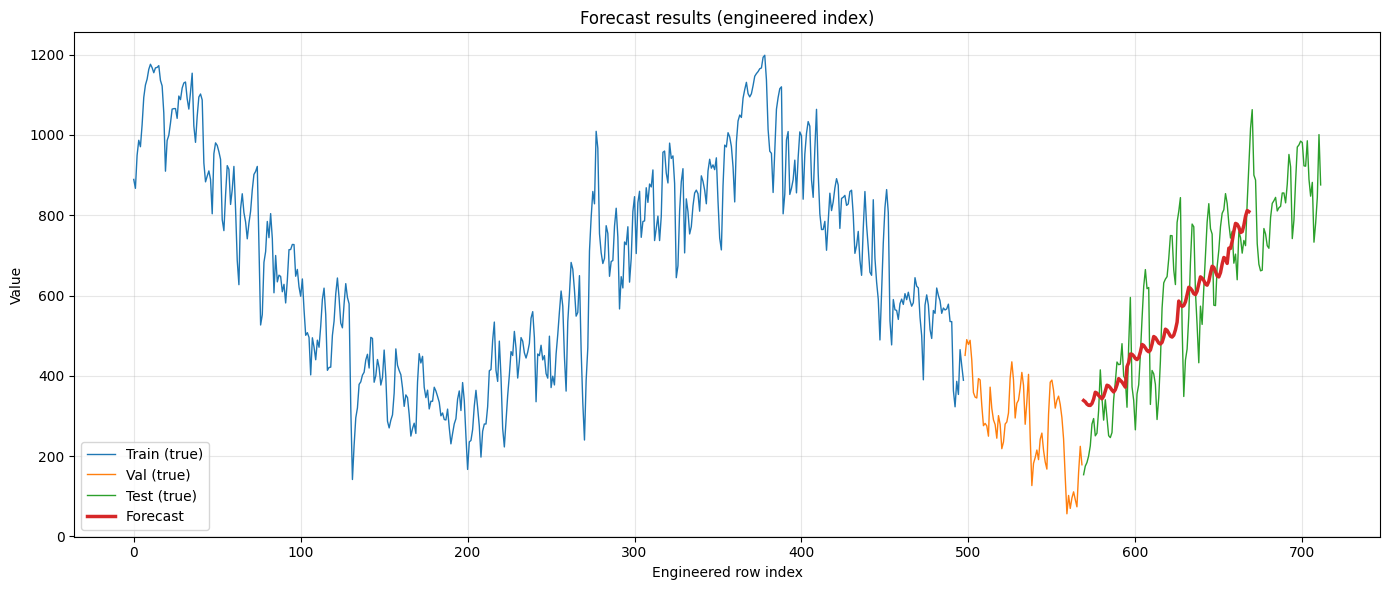

20260112170149_ETTh2_tabular_ld6_ridge
556


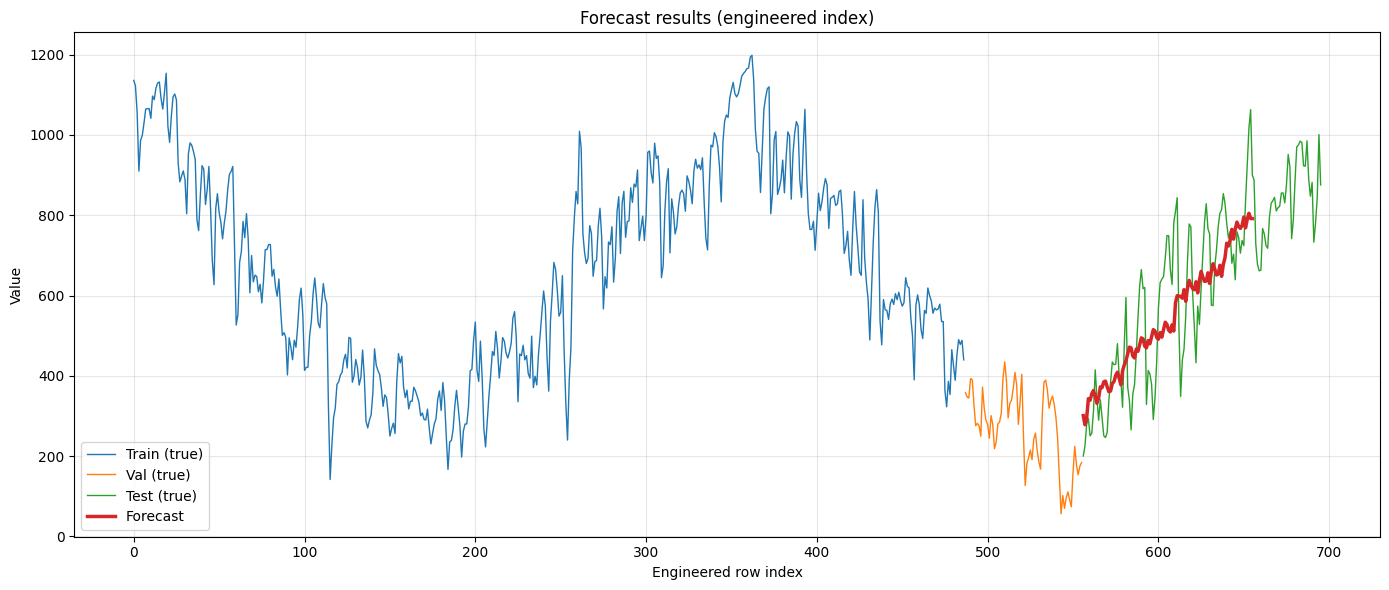

20260112170138_ETTh2_tabular_ld8_ridge
556


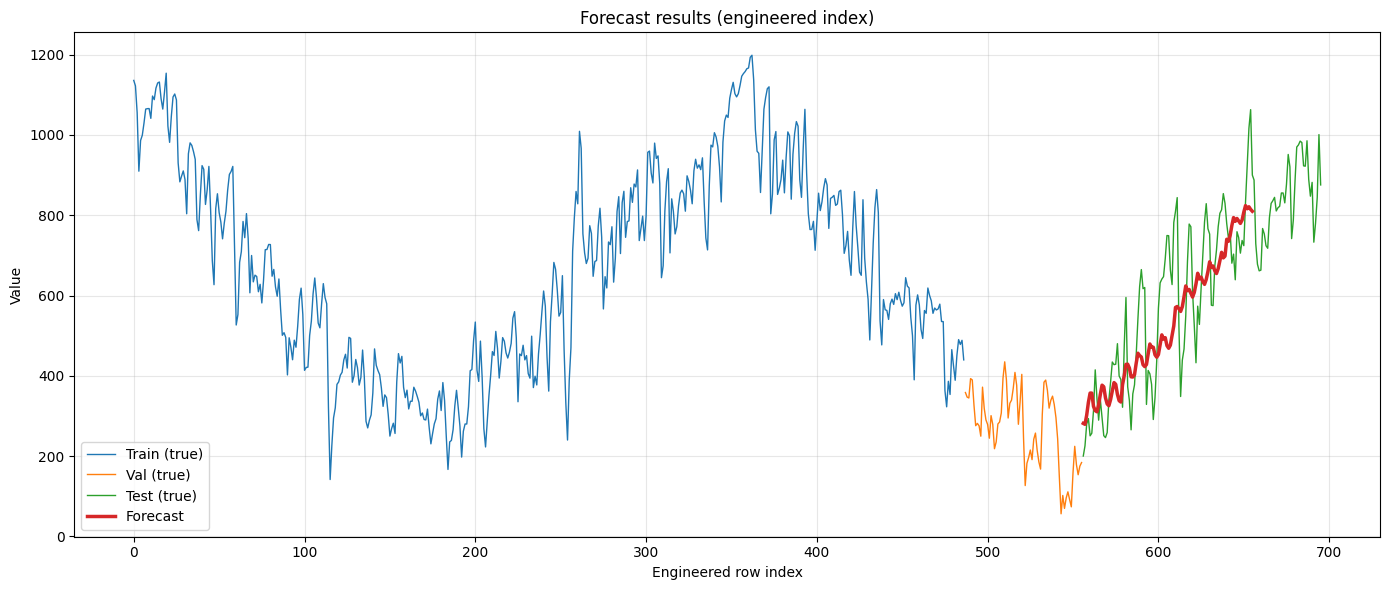

20260112170108_ETTh2_tabular_ld6_random_forest
556


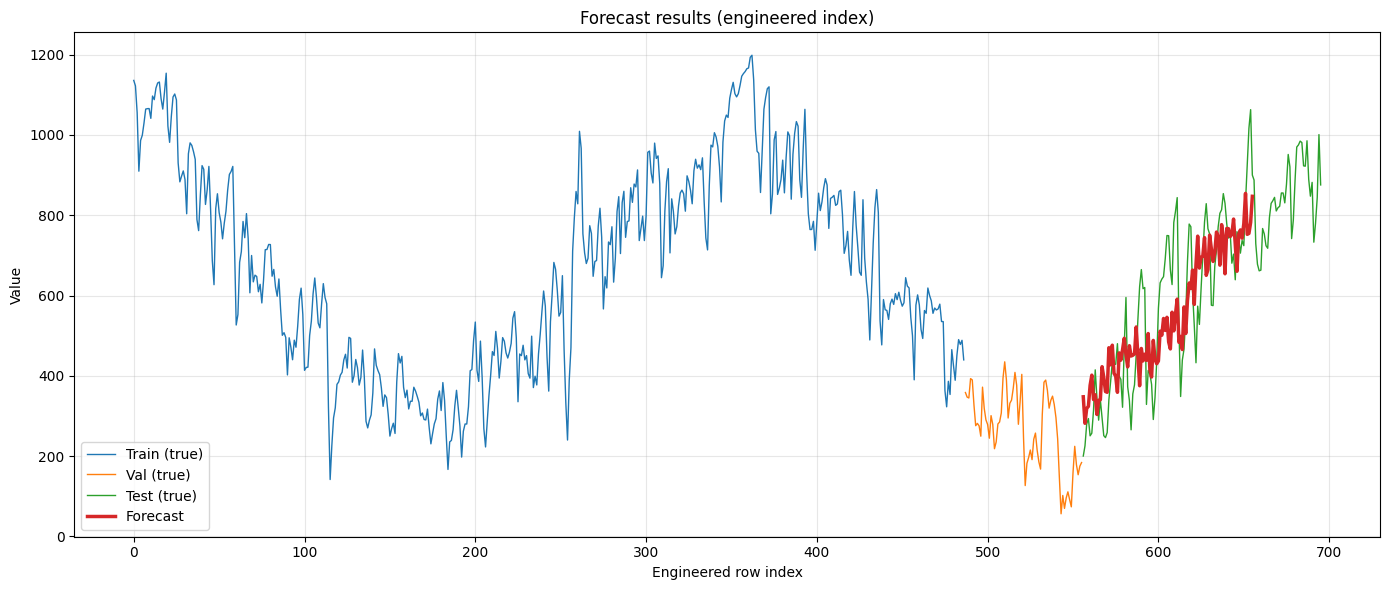

20260112170102_ETTh2_tabular_ld6_ridge
569


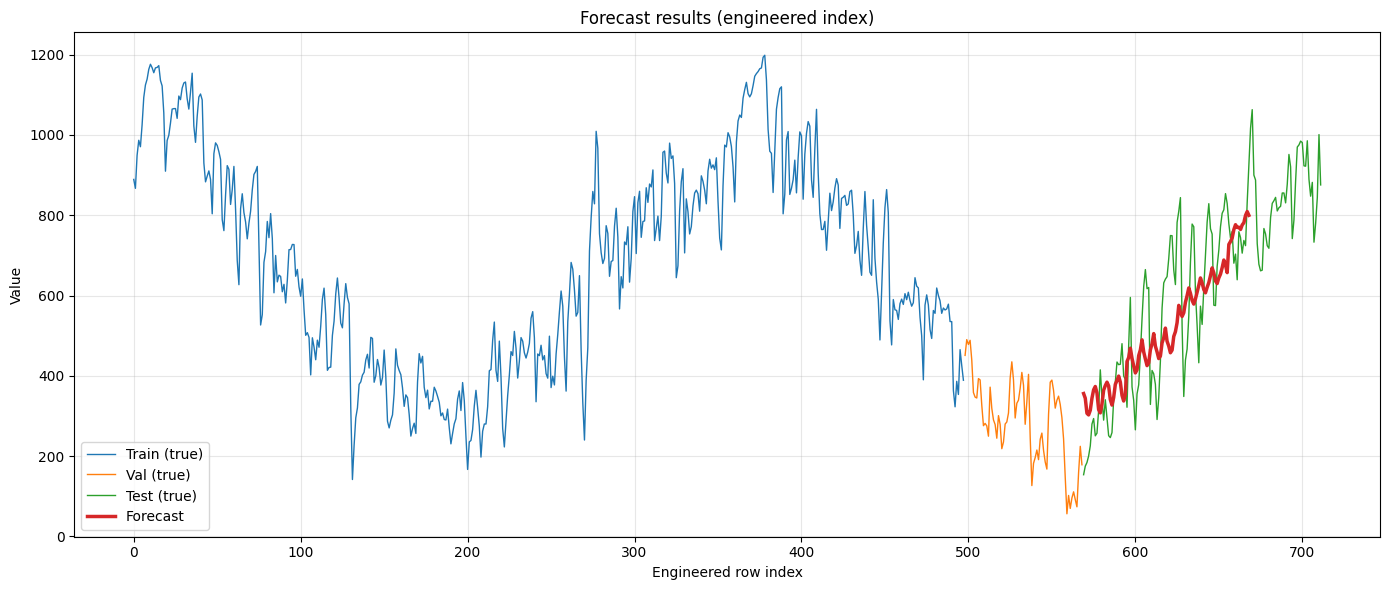

20260112170222_ETTh2_tabular_ld8_ridge
569


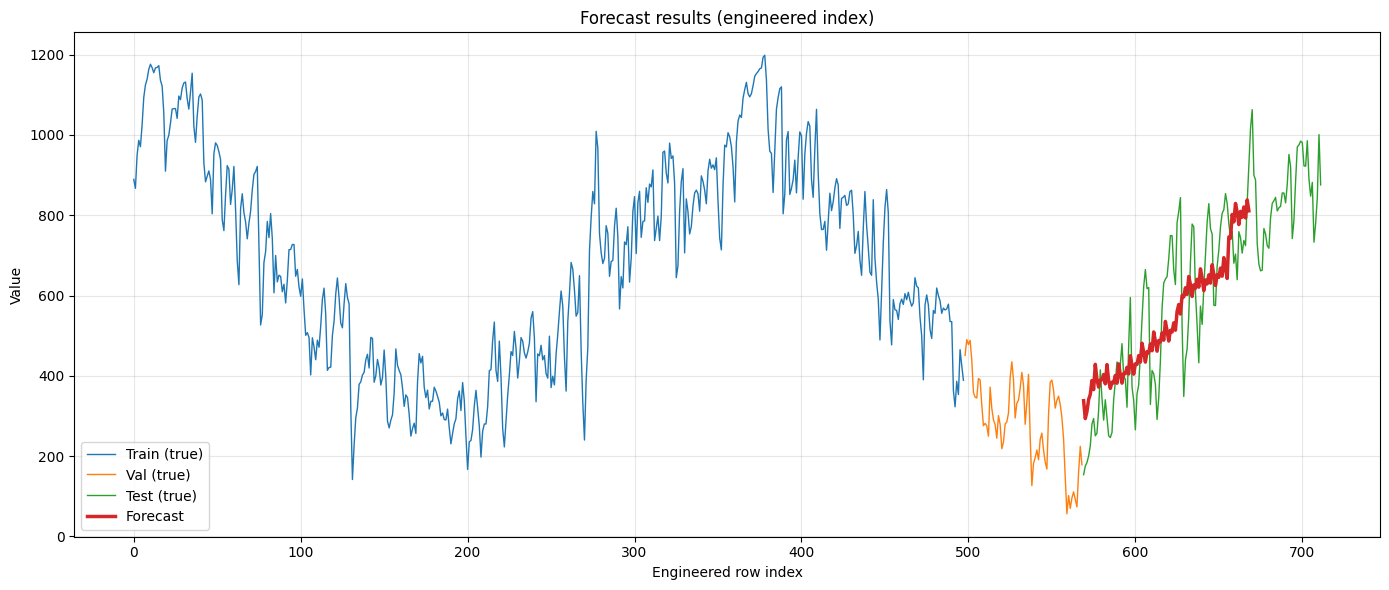

20260112170208_ETTh2_tabular_ld10_ridge
556


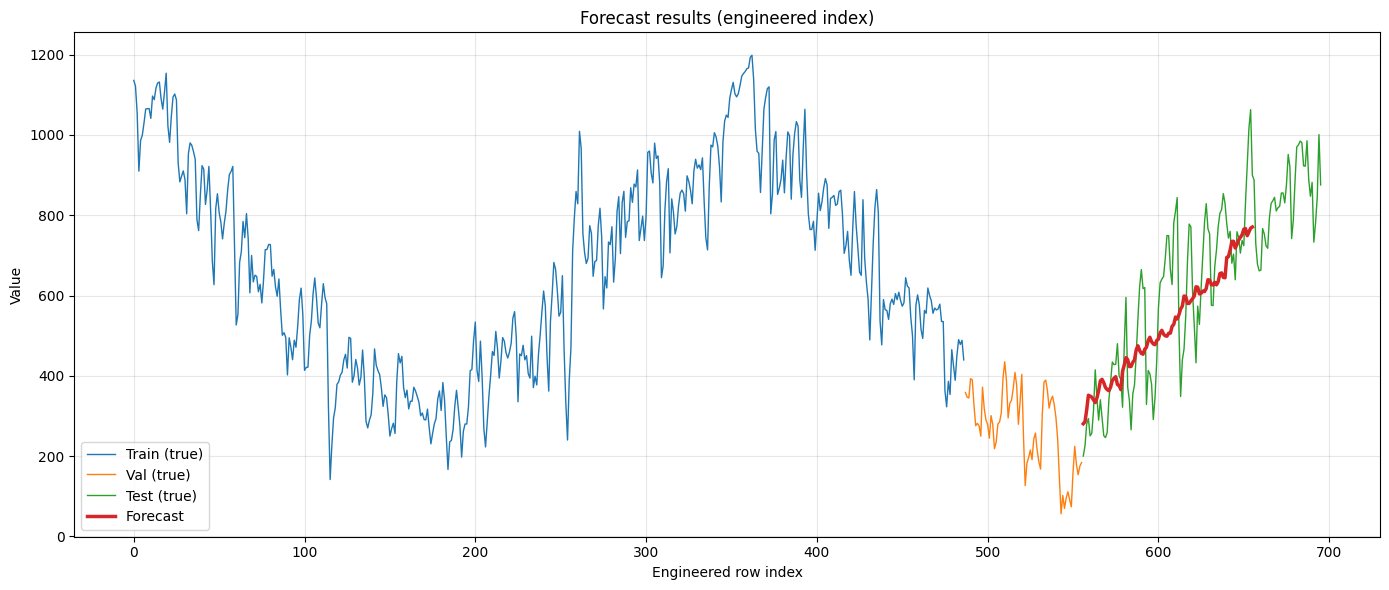

In [116]:
for trial in top10:
    print(trial["name"])
    X_all = trial["X_all"]
    y_pred = trial["y_pred"]
    n_val = trial["n_val_end"]
    n_train = trial["n_train"]
    print(n_val)
    plot_forecast_with_splits(X_all, y_pred, n_train, n_val, start_idx=n_val)